In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
#import hvplot.pandas

raw_listings = pd.read_csv('06 Nov 2020 listings.csv')

print(raw_listings.shape)
raw_listings.head()

(76984, 74)


,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,11551,https://www.airbnb.com/rooms/11551,2.020110e+13,07/11/2020,Arty and Bright London Apartment in Zone 2,Unlike most rental apartments out there my fla...,Not even 10 minutes by metro from Victoria Sta...,https://a0.muscache.com/pictures/b7afccf4-18e5...,43039,https://www.airbnb.com/users/show/43039,...,10.0,9.0,9.0,NaN,t,2,2,0,0,1.48
1,13913,https://www.airbnb.com/rooms/13913,2.020110e+13,07/11/2020,Holiday London DB Room Let-on going,My bright double bedroom with a large window h...,Finsbury Park is a friendly melting pot commun...,https://a0.muscache.com/pictures/miso/Hosting-...,54730,https://www.airbnb.com/users/show/54730,...,10.0,9.0,9.0,NaN,f,2,1,1,0,0.17
2,15400,https://www.airbnb.com/rooms/15400,2.020110e+13,07/11/2020,Bright Chelsea Apartment. Chelsea!,Lots of windows and light. St Luke's Gardens ...,It is Chelsea.,https://a0.muscache.com/pictures/428392/462d26...,60302,https://www.airbnb.com/users/show/60302,...,10.0,10.0,9.0,NaN,t,1,1,0,0,0.67
3,17402,https://www.airbnb.com/rooms/17402,2.020110e+13,06/11/2020,Superb 3-Bed/2 Bath & Wifi: Trendy W1,You'll have a wonderful stay in this superb mo...,"Location, location, location! You won't find b...",https://a0.muscache.com/pictures/39d5309d-fba7...,67564,https://www.airbnb.com/users/show/67564,...,9.0,10.0,9.0,NaN,f,15,15,0,0,0.36
4,17506,https://www.airbnb.com/rooms/17506,2.020110e+13,07/11/2020,Boutique Chelsea/Fulham Double bed 5-star ensuite,Enjoy a chic stay in this elegant but fully mo...,Fulham is 'villagey' and residential – a real ...,https://a0.muscache.com/pictures/11901327/e63d...,67915,https://www.airbnb.com/users/show/67915,...,NaN,NaN,NaN,NaN,f,2,0,2,0,NaN


# Cleaning the Data

In [10]:
to_drop = [
                'listing_url', 'scrape_id', 'name', 'description', 
               'neighborhood_overview', 'picture_url',
               'host_url', 'host_name', 'host_location', 'host_about', 'host_thumbnail_url', 
               'host_verifications', 'neighbourhood', 'neighbourhood_group_cleansed',
               'bathrooms', 'calendar_updated', 'calendar_last_scraped', 
               'license', 'host_picture_url', 
               'host_neighbourhood', 'host_response_time', 'maximum_nights_avg_ntm', 
               'minimum_minimum_nights', 'minimum_maximum_nights',
               'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights',
               'minimum_nights_avg_ntm', 'has_availability', 'calculated_host_listings_count_shared_rooms'
               ]
    

listings = raw_listings.drop(to_drop, axis=1)
   
# Replace columns with categorical values t and f with 1 and 0
listings = listings.replace({'f': 0, 't': 1})
    
# Lambda function to remove special characters and convert to float
strip_and_convert = lambda col: col.str.extract('(\d+)', expand=False).astype(float, errors='ignore')
    
# strip_and_convert function wil be applied on the below columns
cols_to_numeric = ['host_response_rate', 'host_acceptance_rate', 'bathrooms_text', 'price']
listings[cols_to_numeric] = listings[cols_to_numeric].apply(strip_and_convert)
    
# Rename bathrooms_text column
listings = listings.rename(columns={'bathrooms_text': 'bathrooms'})
listings = listings.dropna(subset=['host_since', 'host_is_superhost', 'host_listings_count', 'host_has_profile_pic', 'host_identity_verified'], axis=0)
    
# Convert to datetime object
listings['last_scraped'] = pd.to_datetime(listings['last_scraped'])
listings['host_since'] = pd.to_datetime(listings['host_since'])
    
# Calculoate the difference in days
listings['days_host_since'] = (listings['last_scraped'] - listings['host_since']).dt.days
    
prob = listings['property_type'].value_counts(normalize=True)
    
# Setting a threshold. This threshold means that if the frequency of the property types that is less than this value, they will be categorised as Other
threshold = 0.005
mask = prob > threshold
tail_prob = prob.loc[~mask].sum()
prob = prob.loc[mask]
prob['Other'] = tail_prob
    
# Replace with Other if the frequency of the category is below set threshold (we set it at 0.005, refer to above) 
listings.loc[~listings['property_type'].isin(prob.index.drop('Other')), 'property_type'] = 'Other'
    
fill_median = lambda col: col.fillna(col.median())
listings[['bathrooms', 'bedrooms', 'beds']] = listings[['bathrooms', 'bedrooms', 'beds']].apply(fill_median)
    
# Convert to datetime object
listings['first_review'] = pd.to_datetime(listings['first_review'])
listings['last_review'] = pd.to_datetime(listings['last_review'])
    
# Calculate number of days between review date and the date the dataset was scrapped
listings['days_since_first_review'] = (listings['last_scraped'] - listings['first_review'])
listings['days_since_last_review'] = (listings['last_scraped'] - listings['last_review'])
bins = pd.to_timedelta([0, 182, 365, 730, 1460, max(listings['days_since_first_review'])], unit='days')
labels = ['0-6 months',
               '6-12 months',
               '1-2 years',
               '2-3 years',
               '4+ years']

def categorise_col(col_name, new_col, bins, labels):

    listings[new_col] = pd.cut(listings[col_name], bins, labels=labels)
    listings[new_col] = listings[new_col].astype('str')
    listings[new_col] = listings[new_col].str.replace('nan', 'No reviews')
    listings[new_col] = listings[new_col].astype('category')
        
categorise_col('days_since_first_review', 'days_since_first_review_cats', bins, labels)
bins2 = pd.to_timedelta([0, 14, 60, 182, 365, 730, max(listings['days_since_last_review'])], unit='days')
labels2 = ['0-2 weeks', '2-8 weeks', '2-6 months', '6-12 months', '1 year', '2+ years']
    
categorise_col('days_since_last_review', 'days_since_last_review_cats', bins=bins2, labels=labels2)
listings['days_since_last_review_cats'].isnull().sum();
    
# Categorising columns out of 10
review_cols_10 = ['review_scores_accuracy',
           'review_scores_cleanliness', 'review_scores_checkin',
           'review_scores_communication', 'review_scores_location',
           'review_scores_value']
new_cols_10 = [s + "_cats" for s in review_cols_10]
bins3 = [0, 8, 9, 10]
labels3 = ['0-8/10', '9/10', '10/10']
    
for i, col in enumerate(review_cols_10):
        categorise_col(col, new_cols_10[i], bins=bins3, labels=labels3)
    
# Categorising column out of 10
categorise_col('review_scores_rating', 'review_scores_rating_cat', 
                   bins=[0, 80, 95, 100], 
                   labels=['0-79/100', '80-94/100', '95-100/100'])
    
## Dealing with outliers in prices
listings = listings[listings['price'] < 400]


In [12]:
import time
import re
    
def one_hot_encode_amenities(df):
    '''
    INPUT: 
    df - Original dataframe
    OUTPUT: 
    df_amenities - One-hot encoded dataframe of amenities
        
    Create dummies from list of amenities
    
    '''
    def clean_amenities(row):
        '''
        Remove special characters and split the strings
        '''
        row = re.sub('[^A-Za-z,]+', '_', row).split(",")
        return row
        
    df['amenities'] = df['amenities'].apply(clean_amenities)
    
    # Create columns from list of amenities
    df_amenities = df.amenities.str.join('|').str.get_dummies().add_prefix('amenity')
        
    # Include only those amenities that are found in >5% of the listings
    df_amenities = df_amenities[df_amenities.columns[df_amenities.sum() > 0.05 * len(df_amenities)]]
        
    return df_amenities
    
    

In [13]:
amenities_df = one_hot_encode_amenities(listings)
    
#Concatenate dataframes
listings = pd.concat([listings, amenities_df], axis=1)
fill_mean = lambda col: col.fillna(col.mean())
listings[['host_response_rate', 'host_acceptance_rate', 'reviews_per_month']] = listings[['host_response_rate', 'host_acceptance_rate', 'reviews_per_month']].apply(fill_mean)

# One-hot encoding

In [14]:
# Dropping initial and intermidiate columns
review_cols = listings.columns[listings.columns.str.startswith("review_scores")]
listings = listings.drop(review_cols, axis=1)
listings = listings.drop(columns=['last_review', 
                                  'days_since_last_review', 'days_since_first_review', 
                                  'first_review', 'last_scraped', 'amenities', 'host_since', 'host_listings_count'])

# Include all object and category columns
cat_columns = listings.select_dtypes(include=['object', 'category']).columns
for col in cat_columns:    
    listings = pd.concat([listings.drop(col, axis=1), pd.get_dummies(listings[col], prefix=col, prefix_sep='_', drop_first=True)], axis=1)   

In [15]:
print(listings.shape)
listings.head()

(75487, 133)


,id,host_id,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,latitude,longitude,...,room_type_Shared room,days_since_first_review_cats_1-2 years,days_since_first_review_cats_2-3 years,days_since_first_review_cats_4+ years,days_since_first_review_cats_6-12 months,days_since_last_review_cats_1 year,days_since_last_review_cats_2+ years,days_since_last_review_cats_2-6 months,days_since_last_review_cats_2-8 weeks,days_since_last_review_cats_6-12 months
0,11551,43039,100.000000,100.000000,0.0,3.0,1.0,1.0,51.46225,-0.11732,...,0,0,0,1,0,0,0,1,0,0
1,13913,54730,83.000000,71.000000,0.0,3.0,1.0,1.0,51.56802,-0.11121,...,0,0,0,1,0,0,0,1,0,0
2,15400,60302,100.000000,100.000000,0.0,1.0,1.0,1.0,51.48796,-0.16898,...,0,0,0,1,0,0,0,1,0,0
3,17402,67564,67.000000,100.000000,1.0,18.0,1.0,1.0,51.52195,-0.14094,...,0,0,0,1,0,1,0,0,0,0
4,17506,67915,87.772666,81.321339,0.0,3.0,1.0,1.0,51.47935,-0.19743,...,0,0,0,0,0,0,0,0,0,0


# PCA

In [16]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(listings)

PCA(n_components=2)

In [17]:
print(pca.explained_variance_)
print(pca.explained_variance_ratio_)
print(pca.components_)

[1.00455318e+16 1.23551447e+14]
[0.98621152 0.01212956]
[[ 7.14615864e-02  9.97443340e-01 -1.39206596e-08  2.95993214e-08
  -2.24305296e-10 -7.27468366e-08 -3.32743847e-11 -5.91289030e-10
  -1.80141494e-12 -1.39918404e-11 -1.15323666e-10 -9.10445106e-12
  -2.56212705e-10 -5.45017918e-11 -8.48685901e-09 -3.17170844e-10
  -1.59611347e-04  2.03109719e-08  4.21699447e-08  6.50429618e-08
   1.61816602e-07 -5.33474587e-08  3.35563133e-09  3.72175865e-10
   1.27597617e-09 -6.08026409e-08 -5.56246549e-08 -3.58911400e-09
   5.83201591e-10 -7.73697485e-06  2.63506240e-10 -2.04048010e-11
   2.25696998e-10  9.73503111e-12 -3.60993249e-10  1.32805300e-10
  -2.06500836e-10 -1.72539613e-12 -3.51950415e-11 -1.43683291e-10
  -2.21346527e-10 -1.04473768e-10  8.74003528e-11 -3.85066412e-11
   3.73664460e-10  2.33058248e-10  1.26792339e-10 -2.12912732e-11
  -1.10686849e-10 -1.78487924e-12  3.29806477e-10 -8.70753564e-11
  -2.80298743e-10  1.98865896e-10 -1.62026404e-10  1.53990050e-10
  -1.97508589e-10  7

# PCA without removing outliers in price.

(75487, 2)


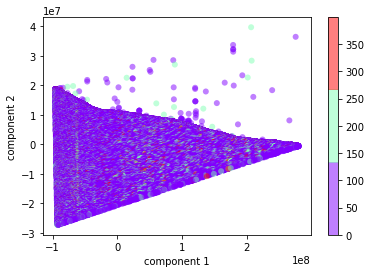

In [18]:
projected = pca.fit_transform(listings)
print(projected.shape)

# plot this PCA projection
plt.scatter(projected[:, 0], projected[:, 1], c=listings['price'],
            edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('rainbow', 3))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar()
plt.show;

# PCA after removing outliers @ price > 400

(76973, 2)


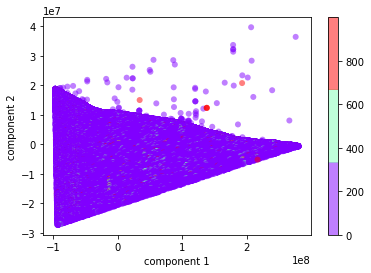

In [9]:
projected = pca.fit_transform(listings)
print(projected.shape)

# plot this PCA projection
plt.scatter(projected[:, 0], projected[:, 1], c=listings['price'],
            edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('rainbow', 3))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar()
plt.show;

# Increasing the components of the PCA

(75487, 10)


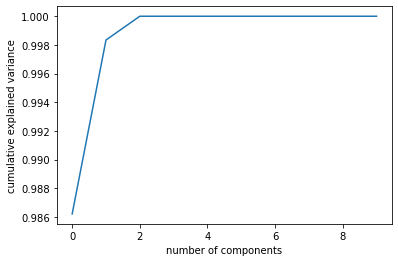

In [19]:
pca = PCA(n_components=10)
pca.fit(listings)

projected = pca.fit_transform(listings)
print(projected.shape)

#plot explained varianace against components
plt.figure
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.show()
plt.close()

(75487, 5)


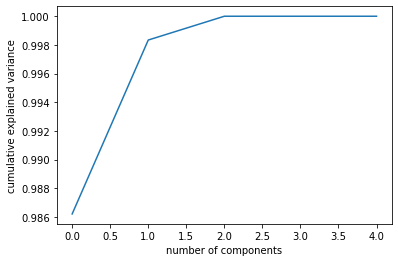

In [20]:
pca = PCA(n_components=5)
pca.fit(listings)

projected = pca.fit_transform(listings)
print(projected.shape)

#plot explained varianace against components
plt.figure
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.show()
plt.close()

(75487, 3)


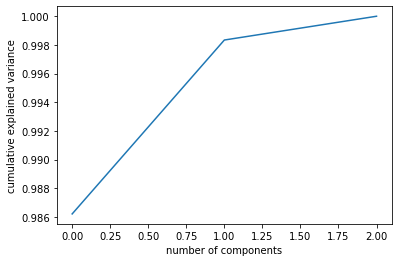

In [21]:
pca = PCA(n_components=3)
pca.fit(listings)

projected = pca.fit_transform(listings)
print(projected.shape)

#plot explained varianace against components
plt.figure
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.show()
plt.close()

(75487, 2)


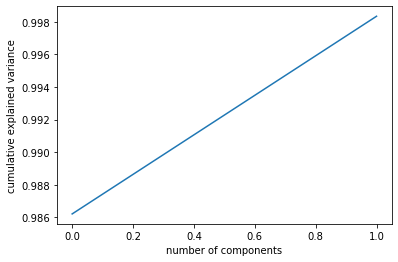

In [22]:
pca = PCA(n_components=2)
pca.fit(listings)

projected = pca.fit_transform(listings)
print(projected.shape)

#plot explained varianace against components
plt.figure
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.show()
plt.close()

In [23]:
listings.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75487 entries, 0 to 76983
Data columns (total 133 columns):
 #    Column                                           Dtype  
---   ------                                           -----  
 0    id                                               int64  
 1    host_id                                          int64  
 2    host_response_rate                               float64
 3    host_acceptance_rate                             float64
 4    host_is_superhost                                float64
 5    host_total_listings_count                        float64
 6    host_has_profile_pic                             float64
 7    host_identity_verified                           float64
 8    latitude                                         float64
 9    longitude                                        float64
 10   accommodates                                     int64  
 11   bathrooms                                        float64
 12   be

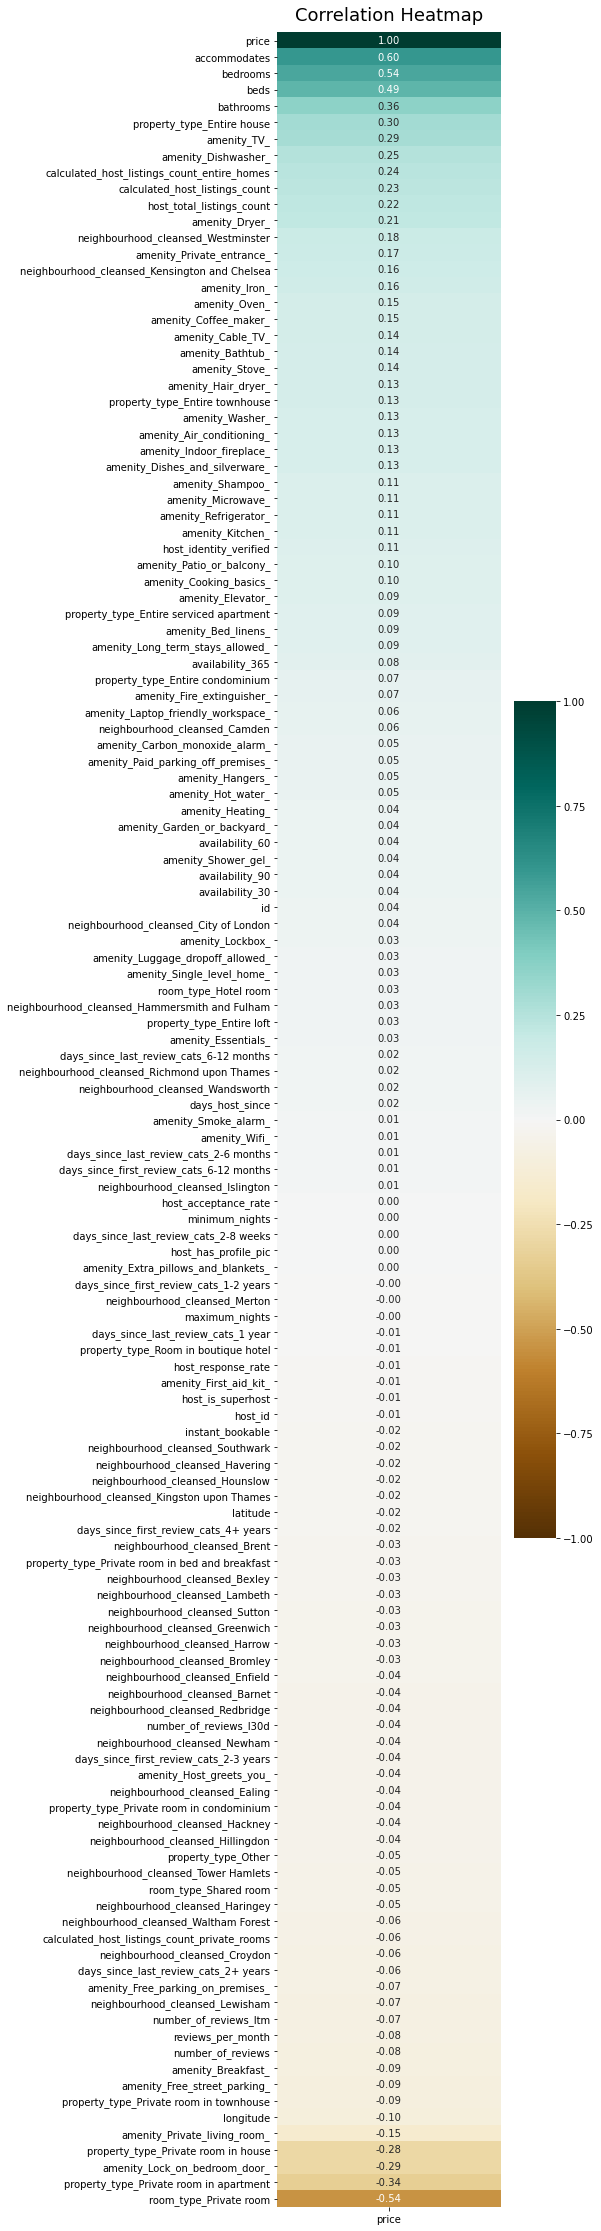

In [24]:
plt.figure(figsize=(5, 40))
feature_correlation = listings.corr()[['price']].sort_values(by='price', ascending=False)
# feature_correlation = feature_correlation[(feature_correlation > 0.1) & (feature_correlation != 1)]
# Show all features.
# heatmap = sns.heatmap(feature_correlation, vmin=-1, vmax=1, annot=True, fmt=".2f", cmap='BrBG')

# Show only price feature
heatmap = sns.heatmap(feature_correlation, vmin=-1, vmax=1, annot=True, fmt=".2f", cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);